# **Importing signal**

## Signal info

In [1]:
import mne
import numpy as np

file = "MiguelRocha_Mont_session_01.edf"
eeg = mne.io.read_raw_edf(f"C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/EEG Data/{file}")

print("\n",eeg.info.keys())
print("\n", eeg.info)

ch = eeg.info["ch_names"] # Channel labels
fs = eeg.info["sfreq"]

print("\nChannel labels: ", ch)

Extracting EDF parameters from C:\Users\migue\OneDrive\Ambiente de Trabalho\Tese\EEG Data\MiguelRocha_Mont_session_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

 dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

 <Info | 7 non-empty values
 bads: []
 ch_names: EEG TP7''-G2, EEG P7''-G2, EEG PO7''-G2, EEG CP5''-G2, EEG ...
 chs: 36 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 120.0 Hz
 meas_date: 2024-03-15 18:08:48 UTC
 nchan: 36
 projs: []
 sfreq: 2048.0 Hz
>

Channel labels:  ["EEG TP7''-G2", "EEG P7''-

## Checking if the recorded signal is an EEG (1/f shape)

### Designing the band pass filter

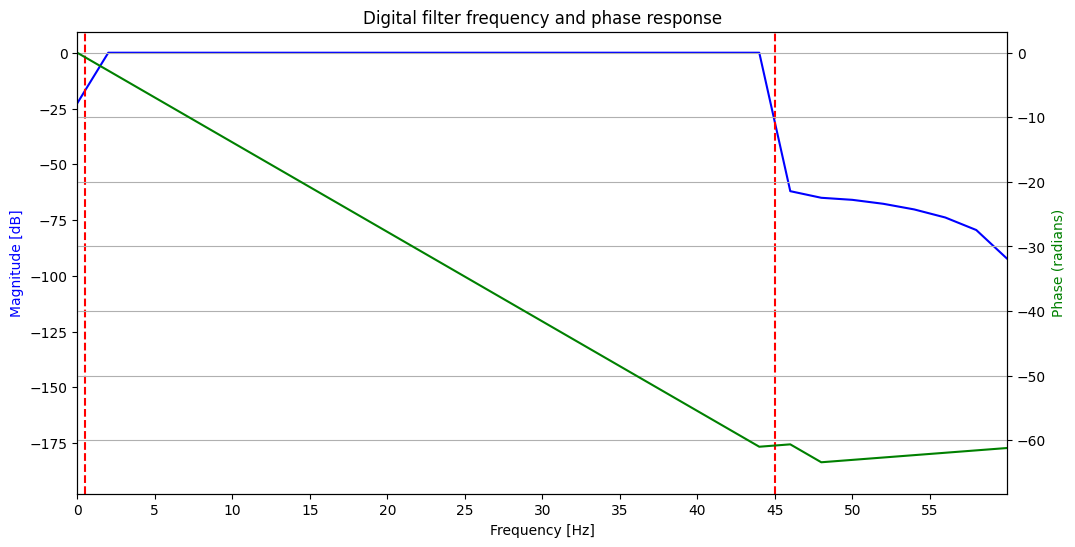

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import scipy
from scipy.signal import filtfilt, firwin, freqz

# Designing a band-pass FIR filter between 0.5 and 45 Hz
nyquist = fs/2
lowcut = 0.5
highcut = 45
numtaps = 5001 # Order
filt = firwin(numtaps, [lowcut/nyquist, highcut/nyquist], pass_zero=False) 
''' 
pass_zero -> If True, the gain at the frequency 0 (i.e., the “DC gain”) is 1. If False, the DC gain is 0. Can also be a string argument for the desired 
filter type (equivalent to btype in IIR design functions).
'''
# Ploting the frequency response of the filter
w, h = freqz(filt) # The frequency response is returned as a tuple (w, h), where w is the array of frequencies and h is the array of complex coeficients (w: rad/samples)

fig, ax1 = plt.subplots(figsize = (12,6))

ax1.set_title('Digital filter frequency and phase response')
ax1.plot(w*fs/(2*np.pi), 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Magnitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_xticks(np.arange(0,highcut * 4/3, 5))

ax1.axvline(x = lowcut, color = 'r', linestyle = '--')
ax1.axvline(x = highcut, color = 'r', linestyle = '--')

ax2 = ax1.twinx()
ax2.plot(w*fs/(2*np.pi), np.unwrap(np.angle(h)), 'g')
ax2.set_ylabel('Phase (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
ax2.set_xlim(0, highcut * 4/3)

plt.show()

# Applying the filter to the signal using filtfilt
# EEG shape: (33, 231936) = (channels, samples)
eeg_ch_idx = mne.pick_channels(ch, include = [], exclude = ['dc01+', 'dc02+', 'MKR+'])
y = filtfilt(filt, 1, eeg.get_data(picks = eeg_ch_idx), axis = 1)


### Apllying the FFT on the EEG signal

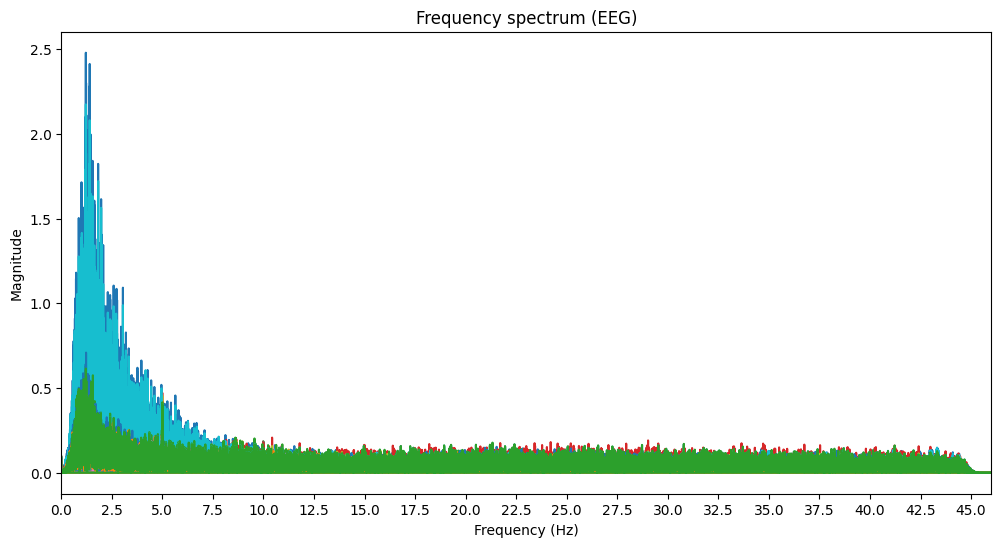

In [3]:
# Compute the FFT of the signal
X = np.fft.fft(y,axis = 1)

# Compute the frequency vector
freqs = np.fft.fftfreq(np.size(X,1), 1/fs)

# Plot the frequency spectrum
figure(figsize = (12,6))
plt.plot(freqs, np.abs(X.T))
plt.title("Frequency spectrum (EEG)")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,highcut + 1)
plt.xticks(np.arange(0,highcut + 1, 2.5)) 
plt.show()

## Isolating the LDR channel

In [14]:
def plot_isolated_signal(time, signal, th, title):
    figure(figsize = (400,20))
    plt.plot(time, signal[:][0], linewidth = 2);
    plt.title(title, fontsize = 100, fontweight = 'bold')
    plt.xlabel('Time (min)', fontsize = 85, fontweight = 'bold')
    plt.ylabel('Voltage (V)', fontsize = 85, fontweight = 'bold')
    plt.xticks(np.arange(0, np.max(time), 0.05), fontsize = 20)
    plt.yticks(np.arange(np.min(signal), np.max(signal), 0.1), fontsize = 20)
    plt.axhline(y = th, color = 'k', linestyle = '--', linewidth = 2)
    plt.grid()

In [15]:
ldr_ch_idx = mne.pick_channels(ch, include = ['dc01+'])
ldr_ch = eeg.get_data(picks = ch[ldr_ch_idx[0]])
if (np.mean(ldr_ch) < 0): # If the polarity was inverted
    print("Inverting signal...")
    ldr_ch = ldr_ch * -1
''' 
The bright square (more light) will decrease the resistance of the LDR, thus producing more voltage
aproximating 2.4V if the polarity of the component was right or -2.4V if the polarity was inverted

The dark square will increase the resistance to the MOhm range and cause the signal to be almost 0.
This is because all the voltage will be sucked by the first component (LDR) of the voltage divider.
'''

time = np.arange(0, np.size(ldr_ch,1)/fs, 1/fs) # Time vector of the acquisition in s
th = 0.3 # y value threshold to segment signal

plot_isolated_signal(time/60, ldr_ch, th, "LDR channel") # time/60 = timevector in minutes

## Filtering the LDR channel (Median filter)

In [8]:
filt_ldr_ch = scipy.signal.medfilt(ldr_ch[:][0],201) 
# A 201 points median filter seems to be enough to smooth the signal without causing phase shifts
# The filter applies a zero pad automatically at the edges

plot_isolated_signal(time/60, ldr_ch, th, "Filtered LDR channel")

# **Segmenting the LDR channel**

In [54]:
preStim_offset = -200 # ms | For baseline correction
posStim_offset = 600 
offset = [int(np.floor(preStim_offset * fs/1000)), int(np.floor(posStim_offset * fs/1000))] # fs/1000 = fs in ms

print(f"{posStim_offset} ms = {offset[1]} samples with a sampling frequency of {int(fs)}")

600 ms = 614 samples with a sampling frequency of 1024


In [55]:
def condition_segmentation(ldr, th, offset):
    
    last_low = True
    
    rising_edges = []
    falling_edges = []

    for index, val in enumerate(ldr):

        if val >= th: # Possible rising edge
            if last_low: # Found rising edge
                rising_edges.append(index + offset[0])
                falling_edges.append(index + offset[1] + 1) 
            
            last_low = False
        
        elif val <= th: # Possible falling edge
            last_low = True

    return rising_edges, falling_edges

rising_edges, falling_edges = condition_segmentation(filt_ldr_ch, th, offset)

plot_isolated_signal(time/60, [filt_ldr_ch], th, "Filtered LDR channel with signal segmentation")
for idx, start_sample in enumerate(rising_edges):
    plt.axvline(x = start_sample/fs/60, color = 'g', linestyle = ':', linewidth = 2)
    plt.axvline(x = falling_edges[idx]/fs/60, color = 'r', linestyle = ':', linewidth = 2)
plt.show()

## Segmenting the EEG data

In [56]:
# Picking the EEG channels (https://mne.tools/stable/auto_tutorials/intro/30_info.html#sphx-glr-auto-tutorials-intro-30-info-py)
print("EEG channel indices: ", eeg_ch_idx)
print("\n")

# Looping through all the segmented 
target_eeg_blocks = []
for idx, start_sample in enumerate(rising_edges):
    target_eeg_blocks.append(eeg.get_data(picks = eeg_ch_idx, start = start_sample, stop = falling_edges[idx]))
    print(f"EEG Block {idx + 1} size: {np.shape(target_eeg_blocks[idx])}")

EEG channel indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


EEG Block 1 size: (33, 820)
EEG Block 2 size: (33, 820)
EEG Block 3 size: (33, 820)
EEG Block 4 size: (33, 820)
EEG Block 5 size: (33, 820)
EEG Block 6 size: (33, 820)
EEG Block 7 size: (33, 820)
EEG Block 8 size: (33, 820)
EEG Block 9 size: (33, 820)
EEG Block 10 size: (33, 820)
EEG Block 11 size: (33, 820)
EEG Block 12 size: (33, 820)
EEG Block 13 size: (33, 820)
EEG Block 14 size: (33, 820)
EEG Block 15 size: (33, 820)
EEG Block 16 size: (33, 820)
EEG Block 17 size: (33, 820)
EEG Block 18 size: (33, 820)
EEG Block 19 size: (33, 820)
EEG Block 20 size: (33, 820)
EEG Block 21 size: (33, 820)
EEG Block 22 size: (33, 820)
EEG Block 23 size: (33, 820)
EEG Block 24 size: (33, 820)
EEG Block 25 size: (33, 820)
EEG Block 26 size: (33, 820)
EEG Block 27 size: (33, 820)
EEG Block 28 size: (33, 820)
EEG Block 29 size: (33, 820)
EEG Block 30 size: (33, 820)
EEG Block 31 

## Ploting the grand-average target EEG response

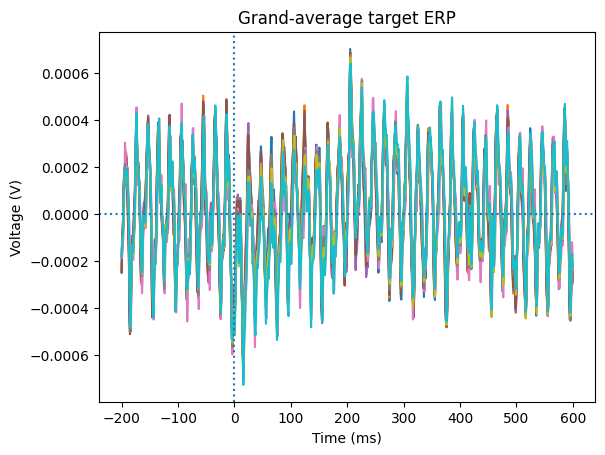

In [57]:
target_erp = np.mean(target_eeg_blocks, axis = 0)
erp_times = np.arange(preStim_offset, posStim_offset, 1000/fs)

plt.plot(erp_times, target_erp[0:10].T);
plt.title("Grand-average target ERP")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.axvline(x = 0, linestyle = ':')
plt.axhline(y = 0, linestyle = ':')

In [ ]:
SCREEN_WIDTH_PX = 1920
SCREEN_HEIGHT_PX = 1080

SCREEN_DIAGONAL_SIZE_INCH = 27

def visual_angle(object_x_px, object_y_px, H_image_width_px, V_image_width_px, screen_width_px, screen_height_px):
    
    # https://www.reddit.com/r/oculus/comments/1dmcsh/default_eye_to_screen_distance/ corresponds to measurement
    #observer_distance_mm = 40 # in mm for the HMD (Oculus Rift)
    OBSERVER_DISTANCE_MM = 1000 # in mm for the C1 computer

    # Width and Height of the screen in mm
    SCREEN_WIDTH_MM = 699
    SCREEN_HEIGHT_MM = 395
 
    # Convert the size of the image in pixels to mm
    H_image_width_mm = (SCREEN_WIDTH_MM * H_image_width_px)/screen_width_px
    V_image_width_mm = (SCREEN_HEIGHT_MM * V_image_width_px)/screen_height_px

    # Visual angle of the image
    H_image_width_deg = np.degrees(2 * (np.arctan(H_image_width_mm / (OBSERVER_DISTANCE_MM * 2))))
    V_image_width_deg = np.degrees(2 * (np.arctan(V_image_width_mm / (OBSERVER_DISTANCE_MM * 2))))

    print(H_image_width_deg)
    print(V_image_width_deg)

    # How many degrees in the visual field represents one pixel in the images
    H_visual_angle_per_px = H_image_width_deg / H_image_width_px 
    V_visual_angle_per_px = V_image_width_deg / V_image_width_px

    H_object_x_deg = (object_x_px - (H_image_width_px / 2)) * H_visual_angle_per_px
    V_object_y_deg = (object_y_px - (V_image_width_px / 2)) * V_visual_angle_per_px

    return H_object_x_deg, V_object_y_deg

In [ ]:
x,y=visual_angle(1134/2, 1344/2 ,1134/2,1344/2, SCREEN_WIDTH_PX, SCREEN_HEIGHT_PX)
print(x,y)

In [ ]:
# This is for the PsycgoPy -> trial -> trialImage -> Layout -> Size[w,h] $

wPx = 1134
hPx = 1344 

print(f"Size [{round(hPx * 0.5 / wPx, 3)}, 0.5]") # This mantains the proportion of width and height in the scalling done in PsychoPy

wPx = 1344 * 0.5 # px
hPx = 1134 * 0.5 # px

# Now we have to define how to devide the visual field for the VR headset
# In the original study had a width of 11.5 x 11.8 degrees and 640 x 640 in pixels. 
# Also, a threshold of +/- 1.2 degrees to classify the images for the LVF and RVF 

#observer_distance_mm = 40
OBSERVER_DISTANCE_MM = 1000

# Inches to mm the screen size
screen_diagonal_size_mm = SCREEN_DIAGONAL_SIZE_INCH * 25.4 

# Angle of the diagonal of the screen
width_height_angle = np.arctan(SCREEN_HEIGHT_PX/SCREEN_WIDTH_PX) # C_oposed/C_adjacent

# Width and Height of the screen in mm
screen_width_mm = 696
screen_height_mm = 395

# Convert the size of the image in pixels to mm
H_image_width_mm = (screen_width_mm * wPx)/SCREEN_WIDTH_PX
V_image_width_mm = (screen_height_mm * hPx)/SCREEN_HEIGHT_PX

# Visual angle of the image
H_image_width_deg = np.degrees(2 * (np.arctan(H_image_width_mm / (OBSERVER_DISTANCE_MM * 2))))
V_image_width_deg = np.degrees(2 * (np.arctan(V_image_width_mm / (OBSERVER_DISTANCE_MM * 2))))

print("\nWidth of the image in degrees: ", round(H_image_width_deg,3))
print("Height of the image in degrees: ", round(V_image_width_deg,3))

# Paper on Eccentricity of the target stimuli and the N2pc performance: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7160023/pdf/nihms-1065363.pdf 
#print("\nNew threshold (H): ", round((1.2 * H_image_width_deg / 11.5),3))
#print("New threshold (V): ", round((1.2 * V_image_width_deg / 11.5),3))

In [ ]:
H_th = 1.2 # Degrees
V_th = 1.2

_, cropped_images = run_fast_scandir(cropped_im_dir, ".jpg")

clearance = 3   # Clearance: 3 x std
h_clearance = 5 # Clearance: 5 x std (Hue/color channel)

all_hsvIms = []
all_conditions = []
all_centroids = []
all_visual_angles = []
all_stim_types = []

t_count = 0
nt_count = 0

for count, im in enumerate(cropped_images):

    # Reads the image using OpenCV
    im = im.replace( '/', '\\')
    img = cv2.imread(im)
    img = cv2.resize(img, None, fx=0.5, fy=0.5)

    all_hsvIms.append(im)
        
    # Image sizes
    height, width, _ = img.shape
    print(f"------- Image {count + 1} -------")
    print(f"Image size: {height} x {width} px")

    # Converts the image from BGR to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    
    #The image is converted to the HSV (Hue, Saturation, Value) color space because it provides a more 
    #intuitive way to represent colors, making it easier to isolate a specific color range, such as red.
    # This is because the whole color information is on the first channel, Hue.

    # Defines the range of red color in HSV (https://colorpicker.me)
    lower_red = np.array([average_h - h_clearance * std_h, average_s - clearance * std_s, average_v - clearance * std_v]) 
    upper_red = np.array([average_h + h_clearance * std_h, average_s + clearance * std_s, average_v + clearance * std_v])

    # Thresholds the image with a mask to get only red pixels
    ''' 
    This binarizes the portions of the image contained between the lower_red and upper_red range.
    The pixel values contained in that HSV range will have the value of 1 and the rest the value 
    of 0 on the binarized image.
    '''
    mask = cv2.inRange(hsv_img, lower_red, upper_red)

    # Finds contours in the binary image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    '''
    cv2.RETR_EXTERNAL: This retrieves only the extreme outer contours. This means it will identify the outermost 
    boundaries of connected components in the foreground (white) regions of the mask image.

    cv2.CHAIN_APPROX_SIMPLE: This method stores only the endpoints of the contours, resulting in a more compressed 
    representation. This is useful for most basic contour analysis tasks as it reduces memory usage and processing time.
    '''

    if contours:
        # Finds the largest contour (assumed to be the red object)
        largest_contour = max(contours, key=cv2.contourArea)

        # Calculates the centroid of the largest contour
        moments = cv2.moments(largest_contour)

        # Checks if moments['m00'] is not zero before division
        if moments['m00'] != 0:
            # Target image was identified
            all_conditions.append("Target")
            t_count += 1
        
            # Image Processing: Moment of Image for Object Detection - https://www.youtube.com/watch?v=RCodqRopMHs
            ''' 
            M00     = Area of the target object in the image (Counts of 1 in the binarized image)
            M10/M00 = Center coordinate of the target object in the x axis
            M01/M00 = Center coordinate of the target object in the y axis
            M11     = Spread of the target object on the x and y directions
            '''
            centroid_x = int(moments['m10'] / moments['m00'])
            centroid_y = int(moments['m01'] / moments['m00'])
            print(f"Target found - Coordinates: [{centroid_x}, {centroid_y}]")
            all_centroids.append([f"x={centroid_x}, y={centroid_y}"])

            # Calculates horizontal and vertical visual angle
            x_VA, y_VA = visual_angle(centroid_x, centroid_y, width, height, SCREEN_WIDTH_PX, SCREEN_HEIGHT_PX)

            if (x_VA > H_th):
                x_stim_type = "RVF"
            elif (x_VA < -H_th):
                x_stim_type = "LVF"
            else:
                x_stim_type = "CVF"

            if(y_VA > V_th):
                y_stim_type = "TVF"
            elif (y_VA < -V_th):
                y_stim_type = "BVF"
            else:
                y_stim_type = "CVF"
             
            all_visual_angles.append([f"x={round(x_VA, 3)},y={round(y_VA, 3)}"])
            all_stim_types.append(x_stim_type + "_" + y_stim_type)

            # Draws a circle at the centroid
            cv2.circle(img, (centroid_x, centroid_y), 12, (255, 50, 50), -1) # radius = 15; thickness = -1; blueish = (255, 50, 50) in BGR
            
            # Displays the image with the centroid to check if the centroid is being determined correctly   
            cv2.imshow('Target image', img)
            cv2.waitKey(1000) # Time that image stays on the screen in ms (Value of 0 makes the window stay open until manually closed)
            cv2.destroyAllWindows()  
            
            
        else:
            # Non target image was identified
            nt_count += 1
            
            all_conditions.append("NonTarget")
            all_centroids.append("0")
            all_visual_angles.append("0")
            all_stim_types.append("0")
            
            print("Non target image")
    else:
        # Non target image was identified
        all_conditions.append("NonTarget")
        all_centroids.append("0")
        all_visual_angles.append("0")
        all_stim_types.append("0")

        print("Non target image")
        
        # Supervising/checking algor
        cv2.imshow('Non-target image',img)
        cv2.waitKey(200)
        cv2.destroyAllWindows()